In [ ]:
pip install --force-reinstall transformers tensorflow keras

  Using cached transformers-4.39.2-py3-none-any.whl (8.8 MB)
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
  Using cached filelock-3.13.3-py3-none-any.whl (11 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached packaging-24.0-py3-none-any.whl (53 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
  Using cached regex-2023.12.25-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached safetensors-0.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Usi

In [ ]:
# !pip install --upgrade tensorflow
!pip install --upgrade torchtext


In [ ]:
!pip install -U torchdata
!pip install datasets
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

  Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2024.2.0 which is incompatible.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("wmt16","de-en", split="train[:50000]")
val_dataset = load_dataset("wmt16","de-en", split="validation")
test_dataset = load_dataset("wmt16","de-en", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 'de', TGT_LANGUAGE: 'en'}

    for data_sample in data_iter:
        if language == SRC_LANGUAGE:
            yield token_transform[language](data_sample['translation'][language_index[language]])
        else:
            yield token_transform[language](data_sample['translation'][language_index[language]])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocab_transform = {}

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_dataset, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)


In [ ]:
print(vocab_transform)

{'de': Vocab(), 'en': Vocab()}


In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.nn.utils.rnn import pad_sequence
from typing import List
from torch.utils.data import DataLoader

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], vocab_transform[ln], tensor_transform)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
!pip install evaluate
!pip install accelerate -U
!pip install bert_score
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets evaluate sentencepiece
!pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Checkpoints'

In [ ]:
import json

# train_dataset1 = load_dataset("wmt16","de-en", split="train[:1000]")
# val_dataset1 = load_dataset("wmt16","de-en", split="validation[:1000]")

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_dataloader = DataLoader(
        list(map(lambda x: (x['translation']['de'], x['translation']['en']), train_dataset)),
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn
    )


    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

def index_to_string(seq, vocab):
    return [vocab.get_itos()[index] if index < len(vocab) else '<unk>' for index in seq]


from datasets import load_metric
import torch
from torch.utils.data import DataLoader
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
import bert_score
from nltk.translate.bleu_score import corpus_bleu

bleu_metric = load_metric('bleu')
bert_metric = load_metric('bertscore')
meteor_metric = load_metric('meteor')

def evaluate(model, k):

    model.eval()
    losses = 0
    bleu_scores = []
    bert_scores = []
    meteor_scores = []

    val_dataloader = DataLoader(
        list(map(lambda x: (x['translation']['de'], x['translation']['en']), val_dataset)),
        batch_size= BATCH_SIZE,
        collate_fn=collate_fn
    )

    with torch.no_grad():

        for src, tgt in val_dataloader:

            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            pred_texts = [index_to_string(seq.tolist(), vocab_transform[TGT_LANGUAGE]) for seq in predictions.cpu()]
            tgt_texts = [index_to_string(seq.tolist(), vocab_transform[TGT_LANGUAGE]) for seq in tgt.cpu()]

            meteor_scores = [meteor_score([reference], prediction) for prediction, reference in zip(pred_texts, tgt_texts)]
            meteor_score_batch = sum(meteor_scores) / len(meteor_scores)
            meteor_scores.append(meteor_score_batch)

            tgt_texts = tgt_texts[1:]


            print("pred_texts[0]: ", pred_texts[0])

            print("tgt_texts[0]: ", tgt_texts[0])


            references = [[refs] for refs in tgt_texts]

            bleu_score_batch = [bleu_metric.compute(predictions=pred_texts, references=references)]
            bleu_scores.append(bleu_score_batch)

            bert_score = bert_metric.compute(predictions=pred_texts, references=tgt_texts, lang="en")
            bert_score_batch = {'precsion':sum(bert_score['precision']) / len(bert_score['precision']), 'recall': sum(bert_score['recall']) / len(bert_score['recall']), 'f1':sum(bert_score['f1']) / len(bert_score['f1'])}
            bert_scores.append(bert_score_batch)

    avg_loss = losses / len(val_dataloader)

    with open(file_path + f'/bleu_scores_epoch_{k}.json', 'w') as file:
        json.dump(bleu_scores, file)


    print("BLUE_SCORES: ", bleu_scores)

    flat_bleu_scores = [score_dict for inner_list in bleu_scores for score_dict in inner_list]


    print(flat_bleu_scores)

    avg_bleu = sum(d['bleu'] for d in flat_bleu_scores) / len(flat_bleu_scores)


    num_precisions = max(len(d['precisions']) for d in flat_bleu_scores)
    avg_precisions = [
        sum(d['precisions'][i] for d in flat_bleu_scores if i < len(d['precisions'])) / len(flat_bleu_scores)
        for i in range(num_precisions)
    ]

    print("Average BLEU score:", avg_bleu)
    print("Average precisions:", avg_precisions)


    bleu_score_dict = { 'bleu': avg_bleu, 'precision': avg_precisions}

    bert_score_dict =  {
                'precision': sum(d['precsion'] for d in bert_scores) / len(bert_scores),
                'recall': sum(d['recall'] for d in bert_scores) / len(bert_scores),
                'f1':  sum(d['f1'] for d in bert_scores) / len(bert_scores)
            }
    meteor_score_final = sum(meteor_scores)/ len(meteor_scores)

    return avg_loss, bleu_score_dict, bert_score_dict, meteor_score_final


<ipython-input-13-a5cc18a96962>:51: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('bleu')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# from timeit import default_timer as timer
# import matplotlib.pyplot as plt

# import os
# import torch
# import re


# def save_checkpoint(model, optimizer, epoch, loss, metrics, filepath):
#     checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'metrics': metrics,
#     }
#     torch.save(checkpoint, filepath)
#     print(f"Checkpoint saved at epoch {epoch}")

# print(f"Loading checkpoint 'model_checkpoint_epoch_2.pth")
# checkpoint = torch.load(file_path + "/model_checkpoint_epoch_2.pth")
# start_epoch = checkpoint['epoch']
# transformer.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# train_losses = checkpoint.get('train_losses', [])
# val_losses = checkpoint.get('val_losses', [])
# metrics = checkpoint.get('metrics', [])

# # print(metrics)


# _, bleu_score, bertscore_result, meteor_result = evaluate(model=transformer, k=2)
# bleu_score['precision_avg'] = (sum(bleu_score['precision']) / len(bleu_score['precision'])) if len(bleu_score['precision'])!=0 else 0
# metrics.append((bleu_score, bertscore_result, meteor_result))



# print("New_val_loss:", _)

# print("hello")
# print("Epoch:", 1)
# print("Training Loss:", train_losses)
# print("Validation Loss:", val_losses)

# print("BLEU SCORE:", bleu_score)
# print("BERT SCORE:", bertscore_result)
# print("METEOR SCORE:", meteor_result)


# # save_checkpoint(transformer, optimizer, epoch, val_loss, metrics, file_path + f'/model_checkpoint_epoch_{epoch}.pth')

FOR DEMO


In [ ]:
# !pip install transformers
import os
import torch
import re

file_path = '/content/drive/MyDrive/Checkpoints'

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def save_checkpoint(model, optimizer, epoch, loss, metrics, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'metrics': metrics,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}")


def find_latest_checkpoint(checkpoint_dir):
    checkpoint_pattern = re.compile(r"model_checkpoint_epoch_(\d+).pth")
    max_epoch = -1
    latest_checkpoint_path = None
    for filename in os.listdir(checkpoint_dir):
        match = checkpoint_pattern.match(filename)
        if match:
            epoch_num = int(match.group(1))
            if epoch_num > max_epoch:
                max_epoch = epoch_num
                latest_checkpoint_path = os.path.join(checkpoint_dir, filename)
    return latest_checkpoint_path

def load_checkpoint(filepath, model, optimizer):
    if filepath and os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        metrics = checkpoint.get('metrics', [])
        print(f"Loaded checkpoint '{filepath}' (epoch {checkpoint['epoch']})")
    else:
        start_epoch = 1
        train_losses = []
        val_losses = []
        metrics = []
        print("No checkpoint found, starting from scratch.")
    return start_epoch, train_losses, val_losses, metrics

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 4
import matplotlib.pyplot as plt

import os
import torch
import re


latest_checkpoint_path = find_latest_checkpoint(file_path)
start_epoch, train_losses, val_losses, metrics = load_checkpoint(latest_checkpoint_path, transformer, optimizer)

for epoch in range(start_epoch, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()

    val_loss, bleu_score, bertscore_result, meteor_result = evaluate(model=transformer, k=epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    metrics.append((bleu_score, bertscore_result, meteor_result))

    print("hello")
    print("Epoch:", epoch)
    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    bleu_score['bleu_avg'] = (sum(bleu_score['precision']) / len(bleu_score['precision'])) if len(bleu_score['precision'])!=0 else 0
    print("BLEU SCORE:", bleu_score)
    print("BERT SCORE:", bertscore_result)
    print("METEOR SCORE:", meteor_result)

    save_checkpoint(transformer, optimizer, epoch, val_loss, metrics, file_path + f'/model_checkpoint_epoch_{epoch}.pth')

plot_losses(train_losses, val_losses)


Loading checkpoint '/content/drive/MyDrive/Checkpoints/model_checkpoint_epoch_2.pth'
Loaded checkpoint '/content/drive/MyDrive/Checkpoints/model_checkpoint_epoch_2.pth' (epoch 2)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


pred_texts[0]:  ['The', 'In', 'Mr', 'The', 'The', 'In', 'In', 'In', 'The', 'The', 'The', 'It', 'The', 'In', 'The', 'In', 'It', 'The', 'In', 'The', 'The', 'The', 'The', 'I', 'This', 'The', 'But', 'The', 'In', 'It', 'In', 'In', 'In', 'In', 'The', 'In', 'In', 'In', 'In', 'As', 'The', 'We', 'The', 'The', 'The', 'The', 'In', 'In', 'In', 'This', 'The', 'The', 'In', 'In', 'The', 'It', 'In', 'In', 'The', 'In', 'It', 'If', 'In', 'In', 'In', 'In', 'In', 'The', 'The', 'The', 'As', 'A', 'In', 'As', 'The', 'In', 'As', 'The', 'In', 'The', 'The', 'The', 'The', 'In', 'The', 'In', 'The', 'It', 'The', 'In', 'In', 'The', 'In', 'In', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'There', 'The', 'The', 'In', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'As', 'We', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'In', 'The', 'It', 'The', 'The', 'We']
tgt_texts[0]:  ['India', 'India', 'Mr', 'High', 'India', '<unk>', 'A', 'Traffic', 'Police', 'The', '<unk>', 'He', 'The', 'George', 'A', 'George'

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred_texts[0]:  ['We', 'In', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'In', 'The', 'The', 'In', 'The', 'The', 'In', 'It', 'In', 'I', 'But', 'The', 'The', 'But', 'What', 'In', 'The', 'What', 'It', 'In', 'It', 'But', 'It', 'But', 'Thank', 'It', 'We', 'What', 'In', 'In', 'The', 'In', 'We', 'There', 'As', 'The', 'Mr', 'In', 'In', 'The', 'They', 'In', 'It', 'In', 'The', 'In', 'The', 'In', 'In', 'In', 'In', 'The', 'The', 'In', 'I', 'The', 'In', 'The', 'The', 'This', 'The', 'The', 'In', 'The', 'The', 'The', 'The', 'It', 'The', 'The', 'Madam', 'The', 'The', 'In', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'In', 'Mr', 'If', 'In', 'The', 'It', 'The', 'The', 'The', 'In', 'It', 'The', 'It', 'The', 'The', 'It', 'It', 'But', 'In', 'In', 'The', 'It', 'In', 'The', 'In', 'The', 'The', 'The', 'The', 'It', 'It', 'In', 'The', 'It', 'But', 'The', 'In', 'A']
tgt_texts[0]:  ['We', '<unk>', '<unk>', 'In', 'The', 'First', '<unk>', 'A', 'The', 'After', 'The', 'The', 'Wind', '<unk>', 'That', 'A', '

KeyboardInterrupt: 

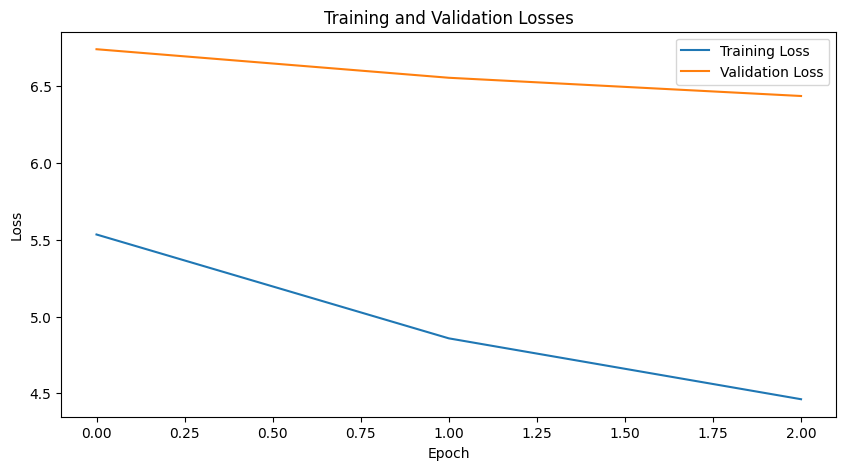

In [ ]:
import matplotlib.pyplot as plt
plot_losses(train_losses, val_losses)

In [ ]:
# !pip install torch

from timeit import default_timer as timer
import torch
import os


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
from transformers import pipeline
import csv
file_path = '/content/drive/MyDrive/Checkpoints'

checkpoint = torch.load(file_path+ '/model_checkpoint_epoch_3.pth')
transformer.load_state_dict(checkpoint['model_state_dict'])


def translate_csv(input_path, output_path):
    with open(input_path, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_path, mode='w', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        writer = csv.DictWriter(outfile, fieldnames=['de', 'en'])
        writer.writeheader()

        for row in reader:
            german_text = row['de']
            english_text = translate(transformer, german_text)
            writer.writerow({'de': german_text, 'en': english_text})


input_csv_path = '/content/german_lines.csv'
output_csv_path = '/content/out.csv'
translate_csv(input_csv_path, output_csv_path)